In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from nltk import word_tokenize, download       
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import tiktoken

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier

from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop

In [10]:
reviews = pd.read_json('data/IMDB_reviews.json', lines=True)
movies = pd.read_json('data/IMDB_movie_details.json', lines=True)

In [11]:
def replace_string_binary(x):
    if x:
        return 1
    return 0

reviews['is_spoiler'] = reviews['is_spoiler'].apply(lambda x: replace_string_binary(x))
reviews

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,1,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,1,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,1,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,1,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,1,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"
...,...,...,...,...,...,...,...
573908,8 August 1999,tt0139239,ur0100166,0,"Go is wise, fast and pure entertainment. Assem...",10,The best teen movie of the nineties
573909,31 July 1999,tt0139239,ur0021767,0,"Well, what shall I say. this one´s fun at any ...",9,Go - see the movie
573910,20 July 1999,tt0139239,ur0392750,0,"Go is the best movie I have ever seen, and I'v...",10,It's the best movie I've ever seen
573911,11 June 1999,tt0139239,ur0349105,0,Call this 1999 teenage version of Pulp Fiction...,3,Haven't we seen this before?


In [12]:
spoiler_reviews = reviews[reviews['is_spoiler'] == 1]['review_text']
corpus_spoilers = ' '.join(spoiler_reviews).split(' ')
corpus_spoilers

['In',
 'its',
 'Oscar',
 'year,',
 'Shawshank',
 'Redemption',
 '(written',
 'and',
 'directed',
 'by',
 'Frank',
 'Darabont,',
 'after',
 'the',
 'novella',
 'Rita',
 'Hayworth',
 'and',
 'the',
 'Shawshank',
 'Redemption,',
 'by',
 'Stephen',
 'King)',
 'was',
 'nominated',
 'for',
 'seven',
 'Academy',
 'Awards,',
 'and',
 'walked',
 'away',
 'with',
 'zero.',
 'Best',
 'Picture',
 'went',
 'to',
 'Forrest',
 'Gump,',
 'while',
 'Shawshank',
 'and',
 'Pulp',
 'Fiction',
 'were',
 '"just',
 'happy',
 'to',
 'be',
 'nominated."',
 'Of',
 'course',
 'hindsight',
 'is',
 '20/20,',
 'but',
 'while',
 'history',
 'looks',
 'back',
 'on',
 'Gump',
 'as',
 'a',
 'good',
 'film,',
 'Pulp',
 'and',
 'Redemption',
 'are',
 'remembered',
 'as',
 'some',
 'of',
 'the',
 'all-time',
 'best.',
 'Pulp,',
 'however,',
 'was',
 'a',
 'success',
 'from',
 'the',
 'word',
 '"go,"',
 'making',
 'a',
 'huge',
 'splash',
 'at',
 'Cannes',
 'and',
 'making',
 'its',
 'writer-director',
 'an',
 'American',

In [13]:
from collections import Counter, defaultdict

dictionnary_spoilers = Counter(corpus_spoilers)
dictionnary_spoilers

Counter({'the': 2672031,
         'and': 1383699,
         'a': 1279892,
         'of': 1214784,
         'to': 1209270,
         'is': 898170,
         'in': 730955,
         'that': 603398,
         'I': 594322,
         'it': 475701,
         'was': 446582,
         'this': 427547,
         'with': 378439,
         'as': 372576,
         'for': 360675,
         'The': 306548,
         'but': 304939,
         'movie': 293261,
         'his': 282251,
         'he': 248975,
         'not': 244383,
         'are': 242600,
         'on': 240965,
         'have': 238159,
         'be': 224681,
         'film': 221675,
         'you': 219984,
         'they': 180151,
         'by': 179783,
         'an': 174264,
         'at': 174205,
         'from': 171348,
         'all': 167642,
         'like': 164087,
         'one': 163259,
         'just': 155950,
         'who': 153535,
         'so': 150593,
         'has': 146935,
         'about': 141956,
         'or': 132878,
         'more':

In [19]:
download('stopwords')
stop_words = set(stopwords.words('english'))

corpus_spoilers = [word for word in corpus_spoilers if not word.lower() in stop_words]
dictionnary_spoilers = Counter(corpus_spoilers)
dictionnary_spoilers

[nltk_data] Downloading package stopwords to /Users/ilyas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Counter({'movie': 296677,
         'film': 223972,
         'one': 178204,
         'like': 170158,
         'would': 108844,
         'really': 105569,
         'good': 101559,
         'even': 97920,
         'see': 94611,
         'story': 85914,
         'much': 81488,
         'first': 80985,
         'get': 80791,
         'also': 78188,
         'great': 73786,
         'time': 72325,
         'people': 69445,
         'could': 68256,
         '-': 68124,
         'character': 65580,
         'make': 65045,
         'think': 63883,
         'many': 58018,
         'best': 57383,
         'way': 56930,
         'well': 55309,
         'characters': 55068,
         'made': 53719,
         'two': 53507,
         'never': 52937,
         'movie.': 52937,
         'know': 50868,
         'love': 49385,
         'little': 48678,
         'scene': 48574,
         'still': 45489,
         'it.': 45117,
         'movies': 45063,
         'go': 44984,
         '': 44352,
         'movie,'

In [20]:
def remove_stop_words(x):
    l = x.split(' ')
    l = [word for word in l if not word.lower() in stop_words]
    return ' '.join(l)


reviews['review_text'] = reviews['review_text'].apply(remove_stop_words)

In [ ]:
reviews
X = reviews['review_text']
y = reviews['is_spoiler']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = make_pipeline(CountVectorizer(ngram_range = (1,1)), LogisticRegression(random_state=0))
model.fit(X_train, y_train)


In [21]:
predicted = model.predict(X_test)
predicted

array([0, 0, 0, ..., 0, 0, 0])

In [23]:
comparatif = pd.DataFrame({"truth" : y_test, "predictions" : predicted})
comparatif

,truth,predictions
287091,0,0
569841,0,0
107090,0,0
162710,0,0
543174,0,0
...,...,...
239323,0,0
403861,1,1
331240,0,0
185458,1,0


In [24]:
print("Classification Report:\n", classification_report(y_test, predicted))

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.95      0.86     84742
           1       0.68      0.29      0.41     30041

    accuracy                           0.78    114783
   macro avg       0.74      0.62      0.64    114783
weighted avg       0.76      0.78      0.74    114783



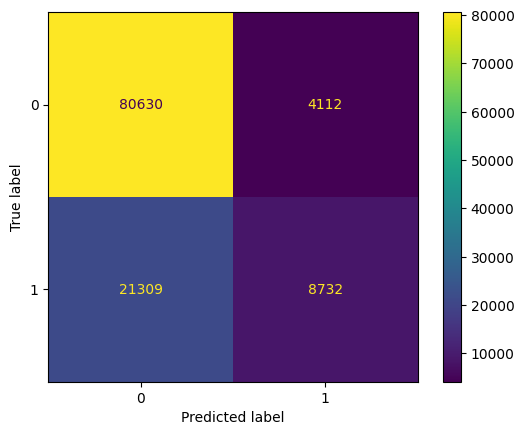

In [25]:
cm = confusion_matrix(y_test, predicted, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
disp.plot()
plt.show()

In [30]:
model.predict(["Lyes dies at the end of the movie"])

array([0])

In [29]:
model_l1 = make_pipeline(CountVectorizer(ngram_range = (1,1)), LogisticRegression(penalty='l1', random_state=0, solver='liblinear'))
model_l1.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('logisticregression',
                 LogisticRegression(penalty='l1', random_state=0,
                                    solver='liblinear'))])

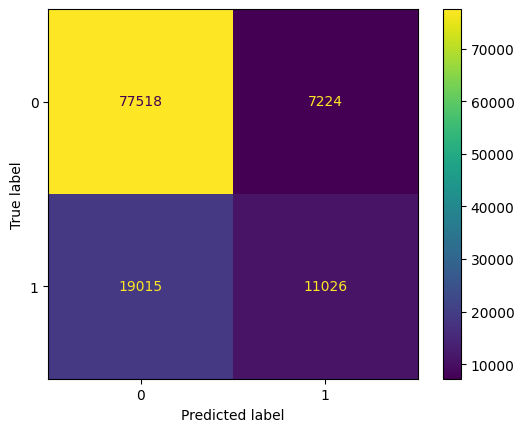

In [32]:
y_pred = model_l1.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
disp.plot()
plt.show()

In [39]:
model.predict([spoil])

array([0])

In [38]:
model_l1.predict([spoil])

array([0])

In [40]:
reviews

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,1,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,1,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,1,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,1,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,1,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"
...,...,...,...,...,...,...,...
573908,8 August 1999,tt0139239,ur0100166,0,"Go is wise, fast and pure entertainment. Assem...",10,The best teen movie of the nineties
573909,31 July 1999,tt0139239,ur0021767,0,"Well, what shall I say. this one´s fun at any ...",9,Go - see the movie
573910,20 July 1999,tt0139239,ur0392750,0,"Go is the best movie I have ever seen, and I'v...",10,It's the best movie I've ever seen
573911,11 June 1999,tt0139239,ur0349105,0,Call this 1999 teenage version of Pulp Fiction...,3,Haven't we seen this before?


In [46]:
reviews[reviews['is_spoiler'] == 1]['review_text'].apply(len).mean()

1887.6767313349765

In [47]:
reviews[reviews['is_spoiler'] == 0]['review_text'].apply(len).mean()

1308.154424819558

In [ ]:
model_3 = make_pipeline(CountVectorizer(ngram_range = (1,1)), LogisticRegression(l1_ratio=0.6, penalty='elasticnet', random_state=0, solver='saga'))
model_3.fit(X_test, y_test)